# **Прогнозирование оттока клиентов новостного портала**

Существует  компания - агрегатор новостей (новостной портал). Необходимо загрузить датасет с новостями, датасет с пользователями и прочитанными ими номерами новостей, датасет с данными оттока, датасет со стоп-словами.

Необходимо построить модель прогнозирования оттока клиентов. Оттоком считается, если клиент перестал посещать сайт.  

Для каждого пользователя в базе данных существует список прочитанных им новостей, для каждой из которых можно извлечь текст. Необходимо понять характеристики пользователя по списку прочитанных им статей, т. е. выделить темы статей и на их основе создать вектор, описывающий пользователя. На его основе создать и обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог). Сформировать на выходе единую таблицу, сравнивающую качество 2/3 разных метода получения эмбедингов пользователей: median, max, idf_mean по метрикам roc_auc, precision, recall, f_score.

# Подготовка данных

Установим необходимые библиотеки.

In [ ]:
! pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 68.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=6f7eda5665016a407fd9b693ab74cf7b0fc2d8a82691d5eff6fc7694aed1891a
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
!pip install razdel

In [ ]:
import itertools
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
from gensim.corpora.dictionary import Dictionary
from nltk.corpus import stopwords
import pymorphy2
from gensim.models import CoherenceModel, LdaModel
from gensim.test.utils import datapath
from google.colab import drive
from razdel import tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
drive.mount('/content/drive')
tqdm.pandas()
nltk.download('stopwords')

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Загрузим данные.

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR" -O articles.csv && rm -rf /tmp/cookies.txt

--2023-11-09 12:58:47--  https://docs.google.com/uc?export=download&confirm=t&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR
Resolving docs.google.com (docs.google.com)... 142.250.152.139, 142.250.152.101, 142.250.152.100, ...
Connecting to docs.google.com (docs.google.com)|142.250.152.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h4nber38qmgl9rf5oo9s6m5c8aidvnan/1699534725000/14904333240138417226/*/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR?e=download&uuid=10bac334-0419-4a1b-b4e9-168aaf5ff6ba [following]
--2023-11-09 12:58:47--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h4nber38qmgl9rf5oo9s6m5c8aidvnan/1699534725000/14904333240138417226/*/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR?e=download&uuid=10bac334-0419-4a1b-b4e9-168aaf5ff6ba
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 172.253.114.

In [ ]:
!wget 'https://drive.google.com/uc?export=download&id=1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a' -O users_articles.csv

--2023-11-09 12:58:52--  https://drive.google.com/uc?export=download&id=1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a
Resolving drive.google.com (drive.google.com)... 74.125.202.102, 74.125.202.139, 74.125.202.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.202.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6cuco3iajfjghssklrr7tfnv6tubuk15/1699534725000/14904333240138417226/*/1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a?e=download&uuid=cfe9e9db-91c6-4915-9048-a0aa3b471b2a [following]
--2023-11-09 12:58:52--  https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6cuco3iajfjghssklrr7tfnv6tubuk15/1699534725000/14904333240138417226/*/1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a?e=download&uuid=cfe9e9db-91c6-4915-9048-a0aa3b471b2a
Resolving doc-04-c0-docs.googleusercontent.com (doc-04-c0-docs.googleusercontent.com)... 172.253.114.132, 2607

In [ ]:
!wget 'https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c' -O stopwords.txt

--2023-11-09 12:58:55--  https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c
Resolving drive.google.com (drive.google.com)... 74.125.202.102, 74.125.202.139, 74.125.202.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.202.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gg7gsbd808rdgdpmg2vv3h99nlijvkhi/1699534725000/14904333240138417226/*/17wVn5YPpMjHToctGgff_KfSeWcIIlf7c?e=download&uuid=82f6a0c0-4721-4403-a007-895e5fc2a089 [following]
--2023-11-09 12:58:55--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gg7gsbd808rdgdpmg2vv3h99nlijvkhi/1699534725000/14904333240138417226/*/17wVn5YPpMjHToctGgff_KfSeWcIIlf7c?e=download&uuid=82f6a0c0-4721-4403-a007-895e5fc2a089
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 172.253.114.132, 2607

In [ ]:
!wget 'https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK' -O users_churn.csv

--2023-11-09 12:58:57--  https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK
Resolving drive.google.com (drive.google.com)... 74.125.202.102, 74.125.202.139, 74.125.202.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.202.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bmiti0vj8nk1186t28a4p4qcpo71h1le/1699534725000/14904333240138417226/*/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK?e=download&uuid=16e449af-d684-4153-8732-e09adc9a0283 [following]
--2023-11-09 12:58:57--  https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bmiti0vj8nk1186t28a4p4qcpo71h1le/1699534725000/14904333240138417226/*/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK?e=download&uuid=16e449af-d684-4153-8732-e09adc9a0283
Resolving doc-0k-c0-docs.googleusercontent.com (doc-0k-c0-docs.googleusercontent.com)... 172.253.114.132, 2607

Выведем несколько строк датасета.

In [ ]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Датасет состоит из столбцов идентификатора документа и текста.  Видим, что в некоторых текстах присутствуют специфичные знаки препинания.

Просмотрим пример текста.


In [ ]:
news.iloc[0]['title']

'Заместитель председателяnправительства РФnСергейnИвановnизбран председателем советаnПБК ЦСКАn. Как сообщаетnпресс-службаnармейцев, такое решение было единогласно принято на первом заседании совета клуба. Основной функцией этого органа будет обсуждение текущего состояния, планирование и утверждение стратегии развития клуба на ближайшую перспективу.nnВ состав совета вошли:nГеоргий Полтавченкоn(полномочный представитель президента в Центральном федеральном округе),nАлексей Седовn(генерал-полковник, начальник службы по защите конституционного строя и борьбе с терроризмомnФСБ РФn),nАлександр Новакn(заместитель министра финансов РФ),nВячеслав Полтавцевn(заместитель генерального директора, руководитель блока по взаимодействию с органами власти, социальной и корпоративной политикиnГМК «Норильский никель»n),nЛеонид Исаковичn(генеральный директор ООО «УК «Спортивные проекты»),nОльга Плешаковаn(генеральный директорn«Трансаэро»n),nАлександр Провоторовn, (генеральный директорnОАО «Ростелеком»n), А

Понимаем, что текст может отражать несколько тем (в примере: политика, спорт, финансы).

Просмотрим датасет пользователей и документов, которые они читали.

In [ ]:
users = pd.read_csv("users_articles.csv")
users.head(3) #

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Нам нужно будет получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей.

Просмотрим датасет, в котором отражена информация, ушел пользователь или нет.

In [ ]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


Загрузим стоп-слова.

In [ ]:
stopword_ru = stopwords.words('russian')
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]

stopword_ru += additional_stopwords
print(len(stopword_ru))
print(stopword_ru)

776
['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 

Создадим функцию clean_text для очистки текста: на вход функция будет принимать текст, приводить его к нижнему регистру, разбивать по пробелам, заменять нечитаемые символы, пробелы, числа, перенос каретки, табуляцию не пробелы.

Также создадим функцию lemmatization для получения списка лемматизированных токенов: если функция получит тип не str - приведет его к str, при помощи razdel токенизирует предложение, проверит, есть ли в начале слова '-', проверит в списке стоп-слов.


In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)

    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):
    if not isinstance(text, str):
        text = str(text)

    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-':
            w = w[1:]
        if len(w) > 1:
            if w in cache:
                words_lem.append(cache[w])
            else:
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)

    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]

    return words_lem_without_stopwords

 Проверим работу функций и выполним преобразования.

In [ ]:
print(news['title'].iloc[:2])
print(news['title'].iloc[:2].apply(lambda x: clean_text(x)))

0    Заместитель председателяnправительства РФnСерг...
1    Матч 1/16 финала Кубка России по футболу был п...
Name: title, dtype: object
0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
Name: title, dtype: object


In [ ]:
%%time
news['title'] = news['title'].progress_apply(lambda x: clean_text(x))

100%|██████████| 27000/27000 [00:34<00:00, 775.90it/s] 

CPU times: user 34.2 s, sys: 222 ms, total: 34.4 s
Wall time: 34.8 s


In [ ]:
news['title'].iloc[:10]

0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
2    форвард авангарда томаш заборский прокомментир...
3    главный тренер кубани юрий красножан прокоммен...
4    решением попечительского совета владивостокско...
5    ио главного тренера вячеслав буцаев прокоммент...
6    запорожский металлург дома потерпел разгромное...
7    сборная сша одержала победу над австрией со сч...
8    бывший защитник сборной россии дарюс каспарайт...
9    полузащитник цска зоран тошич после победы над...
Name: title, dtype: object

In [ ]:
news['title'].iloc[:2].apply(lambda x: lemmatization(x))

0    [заместитель, председатель, правительство, рф,...
1    [матч, финал, кубок, россия, футбол, приостано...
Name: title, dtype: object

In [ ]:
%%time
news['title'] = news['title'].progress_apply(lambda x: lemmatization(x))

100%|██████████| 27000/27000 [04:03<00:00, 110.67it/s]

CPU times: user 3min 47s, sys: 1.31 s, total: 3min 48s
Wall time: 4min 3s


Создадим корпус для обучения.

In [ ]:
texts = list(news['title'].values) # тексты
common_dictionary = Dictionary(texts) # словарь уникальных слов
common_corpus = [common_dictionary.doc2bow(text) for text in texts] # все тексты в списке
len(common_dictionary)

135645

# Выделение тем при помощи  LDA

Далее необходимо подобрать количество тем. Обучим несколько моделей LDA для выделения базовых тем в наборе документов. Выберем модель с наибольшей когерентностью. Когерентность – это степень неслучайной схожести тем. Чем больше показатель когерентности, тем более связаны термины меж собой в темах и тем лучше модель. Подберем модель с наибольшей когерентностью, обучив несколько моделей.

In [ ]:
%%time
gensim_coherence_values = []
gensim_models_list = []

for n_topic in [1, 2, 5, 10, 20, 50, 75, 100]:
  lda = LdaModel(common_corpus, num_topics=n_topic, id2word=common_dictionary, passes=10, random_state=0)
  print(lda)
  gensim_models_list.append(lda)

  coherencemodel = CoherenceModel(model=lda, texts=texts, dictionary=common_dictionary, coherence='c_v')
  gensim_coherence_values.append(coherencemodel.get_coherence())

for i in range(len(gensim_models_list)):
  print(f'{i} {gensim_coherence_values[i]}')

LdaModel<num_terms=135645, num_topics=1, decay=0.5, chunksize=2000>
LdaModel<num_terms=135645, num_topics=2, decay=0.5, chunksize=2000>
LdaModel<num_terms=135645, num_topics=5, decay=0.5, chunksize=2000>
LdaModel<num_terms=135645, num_topics=10, decay=0.5, chunksize=2000>
LdaModel<num_terms=135645, num_topics=20, decay=0.5, chunksize=2000>
LdaModel<num_terms=135645, num_topics=50, decay=0.5, chunksize=2000>
LdaModel<num_terms=135645, num_topics=75, decay=0.5, chunksize=2000>
LdaModel<num_terms=135645, num_topics=100, decay=0.5, chunksize=2000>
0 0.2283434392297042
1 0.29592527347981346
2 0.43913872613376637
3 0.3762368535633205
4 0.4664275657305038
5 0.3925124457437112
6 0.380586021300547
7 0.3489445567601952
CPU times: user 2h 9min 13s, sys: 27min 14s, total: 2h 36min 27s
Wall time: 2h 5min 43s


Наибольшая когерентность получилась при 20 темах.

In [ ]:
N_topic = 20

Сохраним модель.

In [ ]:
temp_file = datapath('/content/drive/MyDrive/lda/model.lda')

In [ ]:
lda_model = gensim_models_list[4]
lda_model.save(temp_file)

И загрузим ее для работы.

In [ ]:
lda = LdaModel.load(temp_file)

Создадим новый корпус, чтобы модель, получив новые тексты, могла снова предсказать. Выполним предсказание на новом тексте: получим слова и вероятности их принадлежности к темам.

In [ ]:
other_texts = list(news['title'].iloc[:3])
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(2, 0.077054456),
 (3, 0.07669492),
 (5, 0.06810583),
 (7, 0.026594235),
 (10, 0.12074938),
 (13, 0.61232144)]

Выведем по 15 слов каждой темы. Слова могут пересекаться, но в целом они должны отражать какую-то определенную тему.

In [ ]:
x = lda.show_topics(num_topics=N_topic, num_words=15, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: россия украина российский глава украинский власть москва министр вопрос сторона рф государство республика политический лидер
topic_1: пенсия высота производитель одежда запустить sa эффективность надпись наращивать литва случайный николас la пепел обернуться
topic_2: день москва обнаружить русский центр сайт выяснить мероприятие площадь московский университет участник столица аэропорт участие
topic_3: военный операция сила действие территория киев турция сторона подчеркнуть оборона турецкий российский конфликт россия дональд
topic_4: писать остров метод умереть мальчик физика япония греция греческий вниз японец пляж сын передовой guardia
topic_5: германия франция французский немецкий рейтинг место испания европа россия польша италия париж второй таиланд гражданство
topic_6: петербург индия занятый конвенция ниша презентовать улыбаться толкать андреев умышленно australia почёт семёрка шмидт паралимпийский
topic_7: тыс млн газ объём около составить вырасти стоимость первый данны

Большинство топиков отражают определенные темы. Можем выделить темы политики, обороны, экономики, медицины, финансов и т.д.

Создадим функцию, которая будет возвращать векторное представление новости. Функция будет принимать на вход текст и модель. Далее модель будет применяться к тексту, и находить, на сколько процентов текст относится к каждой теме. Затем будет создаваться результирующий вектор с вероятностями.

In [ ]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

Проверим работу функции на одном из текстов.



In [ ]:
get_lda_vector(lda, news['title'].iloc[0])

array([0.1325158 , 0.        , 0.        , 0.        , 0.        ,
       0.03099389, 0.        , 0.01056276, 0.        , 0.54939872,
       0.06630534, 0.04357287, 0.        , 0.0916594 , 0.02390374,
       0.04578514, 0.        , 0.        , 0.        , 0.        ])

Получаем, что текст больше всего соответствует 10 теме.

Выведем матрицу принадлежности документа к каждой теме.

In [ ]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

CPU times: user 26.4 s, sys: 14.1 s, total: 40.5 s
Wall time: 28.8 s


,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.132517,0.0,0.000000,0.000000,0.0,0.030985,0.0,0.010563,0.0,...,0.066311,0.043644,0.0,0.091659,0.023829,0.045796,0.000000,0.0,0.000000,0.0
1,4896,0.032892,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.494207,0.000000,0.0,0.394844,0.000000,0.000000,0.056973,0.0,0.000000,0.0
2,4897,0.000000,0.0,0.077019,0.076743,0.0,0.068103,0.0,0.026348,0.0,...,0.120970,0.000000,0.0,0.612338,0.000000,0.000000,0.000000,0.0,0.000000,0.0
3,4898,0.080098,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.078943,0.0,...,0.513201,0.000000,0.0,0.257019,0.000000,0.000000,0.000000,0.0,0.061101,0.0
4,4899,0.000000,0.0,0.000000,0.083763,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.164510,0.000000,0.308636,0.000000,0.0,0.000000,0.0


Создадим векторные представления пользователей. Опишем пользователя одним вектором, где каждый столбец будет темой. Например, если у пользователя 6 тем - получим 6 векторов длиной 20, но можно получить 1 вектор длиной 20, усреднив - опишем пользователя одним вектором, где каждый столбце будет темой.

In [ ]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Создадим словарь из тем и вероятностей.

In [ ]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [ ]:
doc_dict[293672]

array([0.        , 0.        , 0.2703329 , 0.        , 0.        ,
       0.        , 0.        , 0.19414483, 0.03758736, 0.13388017,
       0.        , 0.13519205, 0.        , 0.        , 0.08683131,
       0.        , 0.        , 0.1239625 , 0.        , 0.        ])

Зададим функцию визуализации матрицы ошибок.

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Создадим функцию get_user_embedding для получения вектора пользователя. Функция будет принимать список тем пользователя и функцию, которую будем применять к темам.

In [ ]:
def get_user_embedding(user_articles_list, doc_dict, func):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = func(user_vector, 0)
    return user_vector

# Получение эмбеддингов пользователей и обучение моделей

## Использование mean

Получим эмбединги пользователей при помощи mean.

In [ ]:
user_articles_list = users['articles'].iloc[33]

In [ ]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, np.mean))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

CPU times: user 578 ms, sys: 10.1 ms, total: 588 ms
Wall time: 674 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.115868,0.000000,0.154377,0.070568,0.002864,0.0,0.000000,0.101480,0.029910,...,0.139747,0.059230,0.0,0.012271,0.017501,0.068409,0.012795,0.028888,0.041371,0.051865
1,u108690,0.212064,0.000000,0.040736,0.074224,0.000000,0.0,0.006887,0.027841,0.035667,...,0.273471,0.028634,0.0,0.005513,0.028473,0.050222,0.023739,0.013368,0.092655,0.034895
2,u108339,0.149308,0.016375,0.105899,0.088741,0.000000,0.0,0.000000,0.049851,0.019739,...,0.166229,0.027830,0.0,0.000000,0.016342,0.057695,0.048697,0.000000,0.138448,0.039486


Объединим целевой признак и вектор пользователя.

In [ ]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.115868,0.000000,0.154377,0.070568,0.002864,0.0,0.000000,0.101480,0.029910,...,0.059230,0.0,0.012271,0.017501,0.068409,0.012795,0.028888,0.041371,0.051865,0
1,u108690,0.212064,0.000000,0.040736,0.074224,0.000000,0.0,0.006887,0.027841,0.035667,...,0.028634,0.0,0.005513,0.028473,0.050222,0.023739,0.013368,0.092655,0.034895,1
2,u108339,0.149308,0.016375,0.105899,0.088741,0.000000,0.0,0.000000,0.049851,0.019739,...,0.027830,0.0,0.000000,0.016342,0.057695,0.048697,0.000000,0.138448,0.039486,1


Разделим датасет на train/test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]],
                                                    X['churn'], random_state=0, stratify=X['churn'],
                                                    test_size=0.25)

Обучим базовую модель логистической регрессии.

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

Для каждого пользователя получаем вероятность - уйдет он или нет.

In [ ]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:20]

array([0.1248336 , 0.41663244, 0.00563304, 0.04540793, 0.01726559,
       0.10716429, 0.03232391, 0.08227362, 0.06628933, 0.01013204,
       0.00406128, 0.0987052 , 0.05318991, 0.09755386, 0.16576034,
       0.08160672, 0.00189819, 0.05128906, 0.03344126, 0.01987639])

Визуализируем предсказания.

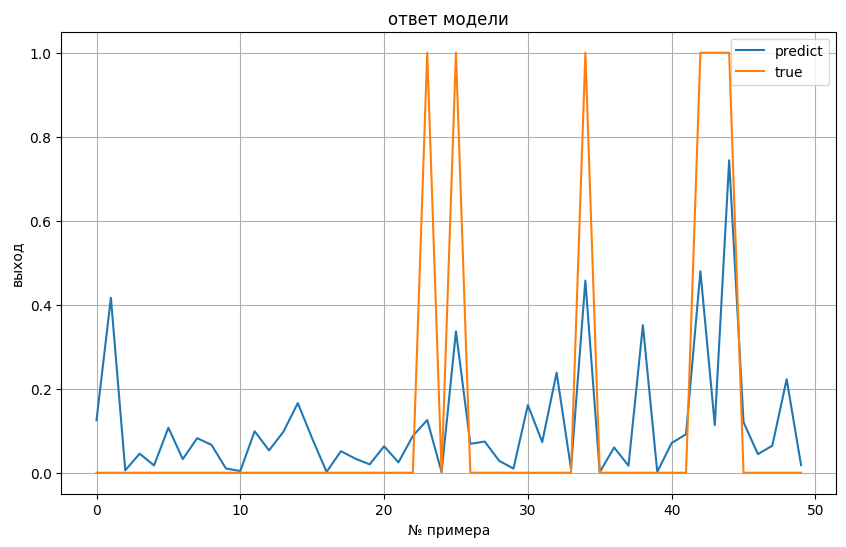

In [ ]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

Видим, что модель не всегда правильно делает предсказание, но хорошо улавливает общую тенденцию.

Рассчитаем precision, recall, порог и индекс максимального усредненного значения f-score.

In [ ]:
precision_mean, recall_mean, thresholds_mean = precision_recall_curve(y_test, preds)
fscore_mean = (2 * precision_mean * recall_mean) / (precision_mean + recall_mean)
ix = np.argmax(fscore_mean)
print(f'Best Threshold={thresholds_mean[ix]}, F-Score={fscore_mean[ix]:.3f}, Precision={precision_mean[ix]:.3f}, Recall={recall_mean[ix]:.3f}')

Best Threshold=0.294684299483987, F-Score=0.755, Precision=0.746, Recall=0.764


Визуализируем матрицу ошибок.

Confusion matrix, without normalization
[[1685   65]
 [  60  190]]


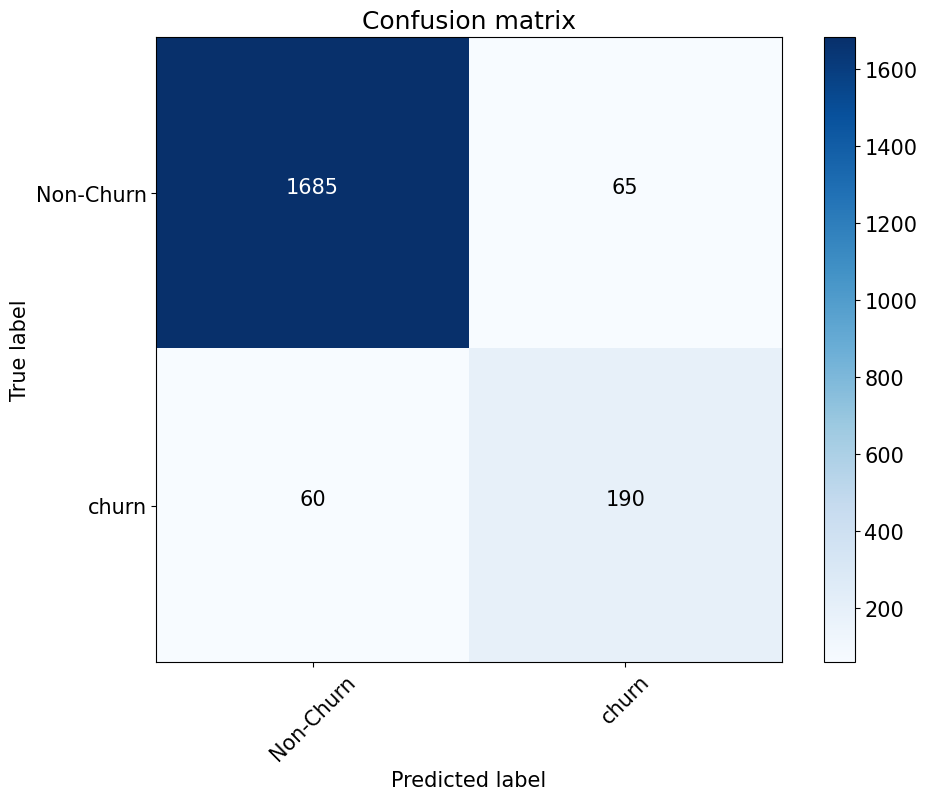

In [ ]:
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, preds > thresholds_mean[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Модель правильно предсказала, что 190 пользователей уйдут, 1685 пользователей останутся. Также модель 65 раз совершила ошибку первого рода, т. е. предсказала, что пользователь уйдет, а он на самом деле остался. Это значит, что бизнес зря понес расходы на удержание этих людей, они итак не собирались уходить. И также модель 60 раз совершила ошибку 2 рода, т. е. ошибочно предсказала, что пользователь не уйдет. Эта ошибка означает, что мы могли попробовать удержать этих людей, но так как мы не отследили их намерение, то потеряли потенциальную прибыль.



Рассчитаем значение ROC AUC, чтобы понять насколько хорошо модель отличает классы между собой.

In [ ]:
roc_auc_score_mean = roc_auc_score(y_test, preds)
roc_auc_score_mean

0.966169142857143

Roc_auc_score = 0.966, что является хорошим результатом.

## Использование median

Теперь попробуем использовать median вместо mean при получении эмбеддингов пользователей.

In [ ]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, np.median))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

CPU times: user 1.11 s, sys: 16.6 ms, total: 1.12 s
Wall time: 2.26 s


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.113008,0.0,0.169020,0.080245,0.0,0.0,0.0,0.045821,0.018794,...,0.148711,0.032766,0.0,0.0,0.0,0.000000,0.009092,0.0,0.008449,0.000000
1,u108690,0.226383,0.0,0.031593,0.062034,0.0,0.0,0.0,0.008837,0.000000,...,0.287879,0.034765,0.0,0.0,0.0,0.006398,0.000000,0.0,0.095323,0.000000
2,u108339,0.108857,0.0,0.106662,0.061701,0.0,0.0,0.0,0.052566,0.000000,...,0.160515,0.036278,0.0,0.0,0.0,0.042354,0.052839,0.0,0.135060,0.031762


Объединим целевой признак и вектор пользователя.

In [ ]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.113008,0.0,0.169020,0.080245,0.0,0.0,0.0,0.045821,0.018794,...,0.032766,0.0,0.0,0.0,0.000000,0.009092,0.0,0.008449,0.000000,0
1,u108690,0.226383,0.0,0.031593,0.062034,0.0,0.0,0.0,0.008837,0.000000,...,0.034765,0.0,0.0,0.0,0.006398,0.000000,0.0,0.095323,0.000000,1
2,u108339,0.108857,0.0,0.106662,0.061701,0.0,0.0,0.0,0.052566,0.000000,...,0.036278,0.0,0.0,0.0,0.042354,0.052839,0.0,0.135060,0.031762,1


Разделим датасет на train/test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]],
                                                    X['churn'], random_state=0, stratify=X['churn'],
                                                    test_size=0.25)

Обучим такую же модель логистической регрессии.

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

Для каждого пользователя получаем вероятность - уйдет он или нет.

In [ ]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:20]

array([0.31607638, 0.26312937, 0.00330095, 0.05613674, 0.02763059,
       0.21201172, 0.01937106, 0.0261398 , 0.07340541, 0.02442948,
       0.00351861, 0.3003358 , 0.12181555, 0.10929997, 0.15364312,
       0.13400765, 0.00151178, 0.1015724 , 0.02801326, 0.03782679])

Визуализируем предсказания.

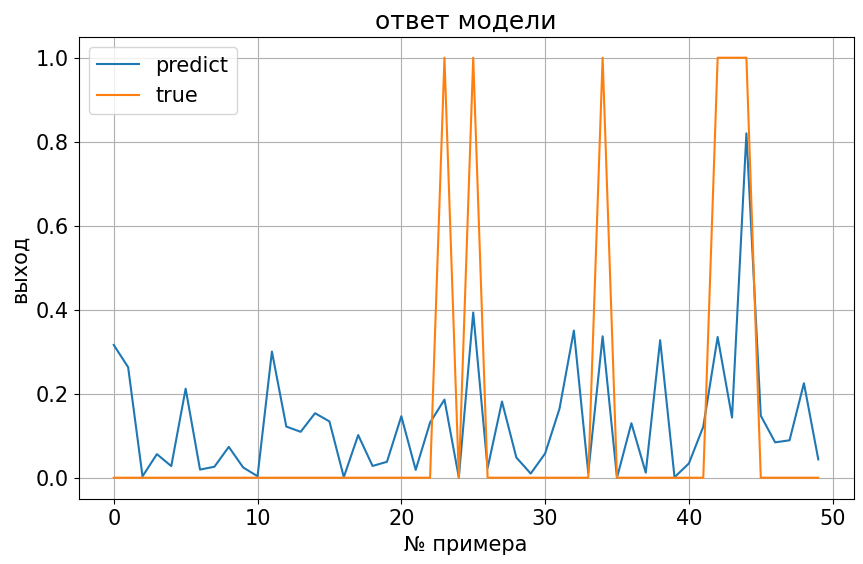

In [ ]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

Видим, что модель не всегда правильно делает предсказание, но хорошо улавливает общую тенденцию, при этом график почти не отличается от предыдущей модели.

Рассчитаем precision, recall, порог и индекс максимального усредненного значения f-score.

In [ ]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_test, preds)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
ix = np.argmax(fscore_median)
print(f'Best Threshold={thresholds_median[ix]}, F-Score={fscore_median[ix]:.3f}, Precision={precision_median[ix]:.3f}, Recall={recall_median[ix]:.3f}')

Best Threshold=0.2699488802789464, F-Score=0.762, Precision=0.732, Recall=0.796


Значение Best_Threshold изменилось, значение F-Score немного выросло, значения Precision и  Recall стали немного ниже.

Визуализируем матрицу ошибок.

Confusion matrix, without normalization
[[1681   69]
 [  61  189]]


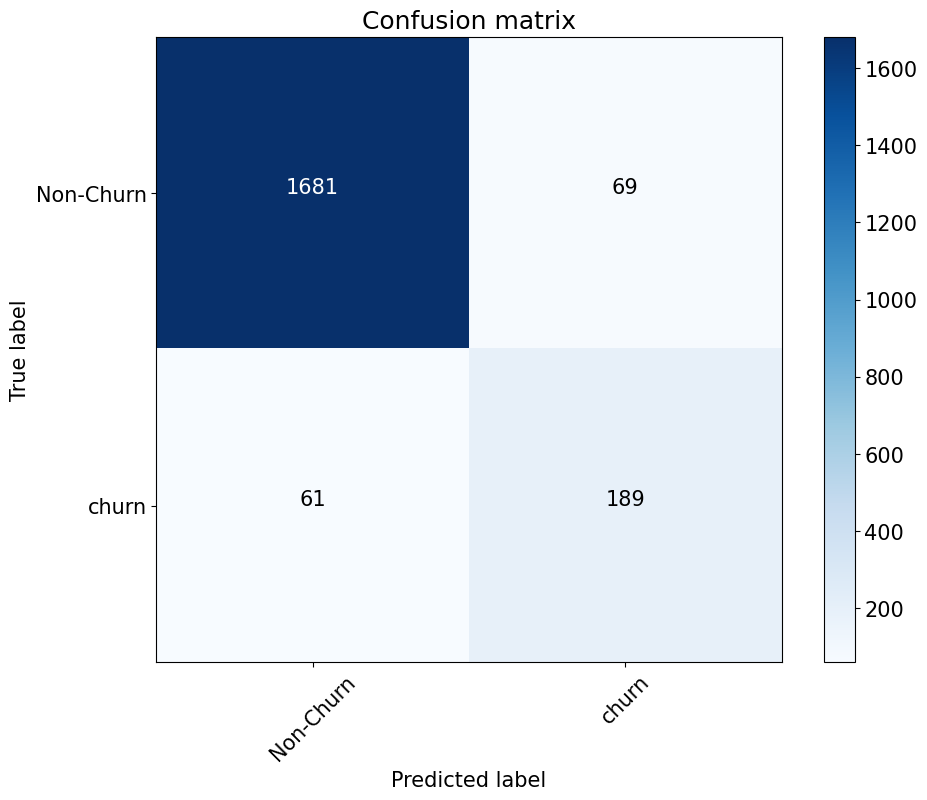

In [ ]:
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, preds > thresholds_mean[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Модель правильно предсказала, что 189 пользователей уйдут, 1681 пользователей останутся. Также модель 69 раз совершила ошибку первого рода, т. е. предсказала, что пользователь уйдет, а он на самом деле остался. И также модель 61 раз совершила ошибку 2 рода, т. е. ошибочно предсказала, что пользователь не уйдет. Получаем, что количество ошибочных и правильных предсказаний примерно находятся на том же уровне, что и у предыдущей модели.

Рассчитаем значение ROC AUC, чтобы понять насколько хорошо модель отличает классы между собой.


In [ ]:
roc_auc_score_median = roc_auc_score(y_test, preds)
roc_auc_score_median

0.9697462857142856

Roc_auc_score = 0.97, что немного больше, чем у предыдущей модели.

Теперь попробуем использовать функцию max для получения эмбеддингов пользователей.

## Использование max

In [ ]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, np.max))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

CPU times: user 458 ms, sys: 3.86 ms, total: 462 ms
Wall time: 511 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.301047,0.00000,0.270333,0.132587,0.017186,0.0,0.000000,0.323095,0.079868,...,0.286523,0.154655,0.0,0.073627,0.086831,0.272127,0.035319,0.123962,0.175708,0.182437
1,u108690,0.263001,0.00000,0.117295,0.136533,0.000000,0.0,0.027838,0.115725,0.120800,...,0.416095,0.064473,0.0,0.033079,0.105582,0.246121,0.125521,0.045292,0.146181,0.128499
2,u108339,0.368959,0.08013,0.234114,0.191867,0.000000,0.0,0.000000,0.109647,0.096380,...,0.257386,0.051824,0.0,0.000000,0.067416,0.136753,0.104840,0.000000,0.304822,0.105359


Объединим целевой признак и вектор пользователя.

In [ ]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.301047,0.00000,0.270333,0.132587,0.017186,0.0,0.000000,0.323095,0.079868,...,0.154655,0.0,0.073627,0.086831,0.272127,0.035319,0.123962,0.175708,0.182437,0
1,u108690,0.263001,0.00000,0.117295,0.136533,0.000000,0.0,0.027838,0.115725,0.120800,...,0.064473,0.0,0.033079,0.105582,0.246121,0.125521,0.045292,0.146181,0.128499,1
2,u108339,0.368959,0.08013,0.234114,0.191867,0.000000,0.0,0.000000,0.109647,0.096380,...,0.051824,0.0,0.000000,0.067416,0.136753,0.104840,0.000000,0.304822,0.105359,1


Разделим датасет на train/test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]],
                                                    X['churn'], random_state=0, stratify=X['churn'],
                                                    test_size=0.25)

Обучим такую же модель логистической регрессии.

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

Для каждого пользователя получаем вероятность - уйдет он или нет.

In [ ]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:20]

array([0.08272278, 0.18013561, 0.00083852, 0.12466835, 0.00224585,
       0.09076595, 0.02123294, 0.1213698 , 0.04039325, 0.00388882,
       0.00180652, 0.03050319, 0.00968723, 0.09769808, 0.02567229,
       0.1769666 , 0.00056674, 0.00934295, 0.0108261 , 0.00224025])

Визуализируем предсказания.

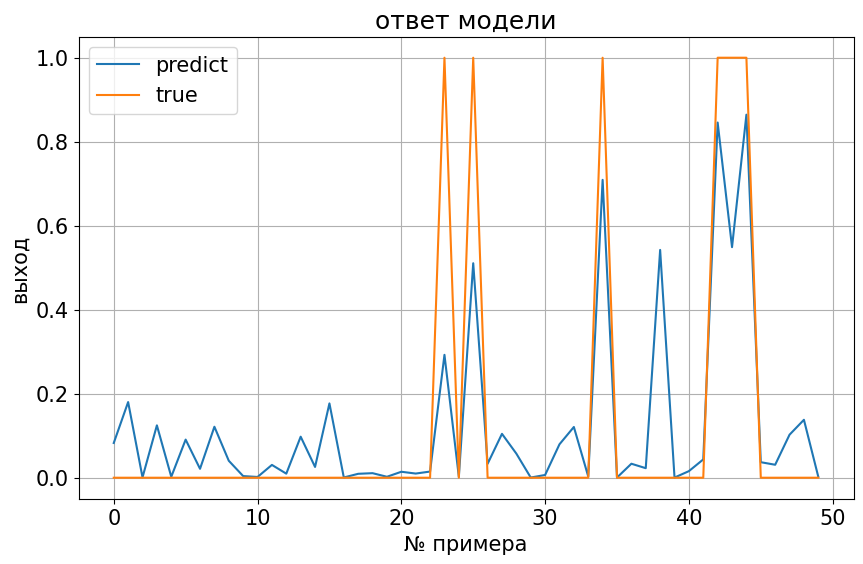

In [ ]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

Видим, что модель лучше отражает данные, хотя тоже совершает ошибки.

Рассчитаем precision, recall, порог и индекс максимального усредненного значения f-score.

In [ ]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_test, preds)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
ix = np.argmax(fscore_max)
print(f'Best Threshold={thresholds_max[ix]}, F-Score={fscore_max[ix]:.3f}, Precision={precision_max[ix]:.3f}, Recall={recall_max[ix]:.3f}')

Best Threshold=0.31846746878073906, F-Score=0.796, Precision=0.754, Recall=0.844


Значение Best_Threshold изменилось, значения F-Score, Precision и Recall выросли.

Визуализируем матрицу ошибок.

Confusion matrix, without normalization
[[1670   80]
 [  32  218]]


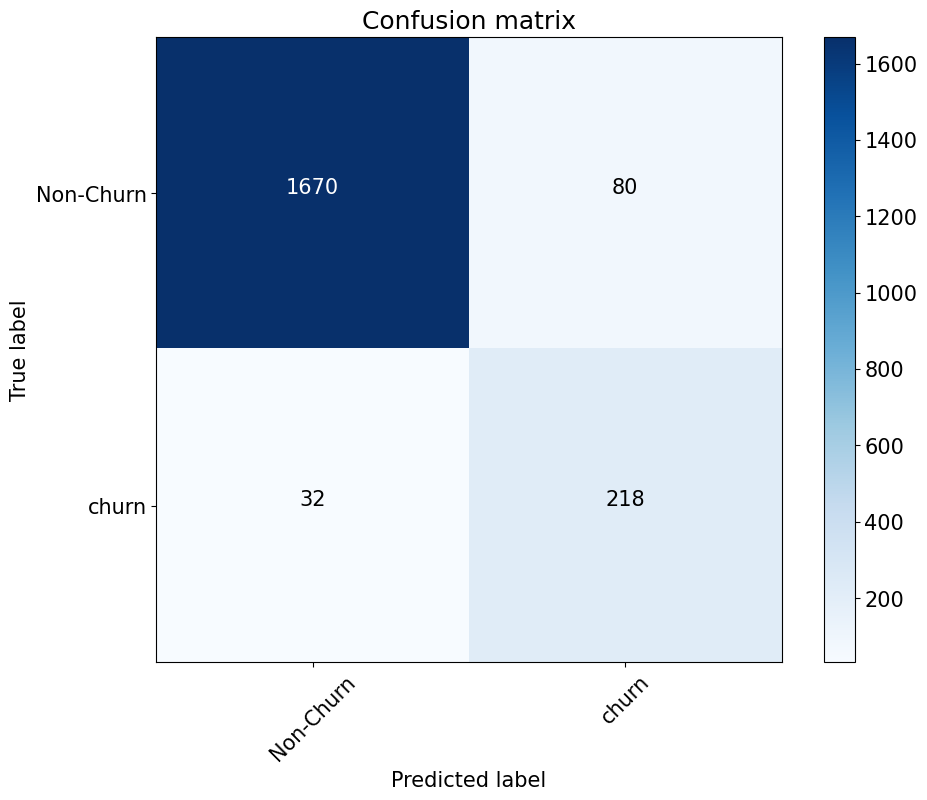

In [ ]:
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, preds > thresholds_mean[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Модель правильно предсказала, что 218 пользователей уйдут, 1670 пользователей останутся. Также модель 80 раз совершила ошибку первого рода, т. е. предсказала, что пользователь уйдет, а он на самом деле остался. И также модель 32 раза совершила ошибку 2 рода, т. е. ошибочно предсказала, что пользователь не уйдет. Данной модели удалось значительно снизить ошибки второго рода.

Рассчитаем значение ROC AUC, чтобы понять насколько хорошо модель отличает классы между собой.


In [ ]:
roc_auc_score_max = roc_auc_score(y_test, preds)
roc_auc_score_max

0.9731725714285715

Значение roc_auc еще немного увеличилось.  

## Использование TF-IDF



Теперь попробуем использовать  TF-IDF для получения эмбеддингов пользователей. Предположительно, за счет оценки важности слова в контексте документа относительно коллекции корпуса, TF-IDF  поможет создать более информативные векторные представления для алгоритма.

In [ ]:
users['articles_'] = users['articles'].apply(lambda x: x.replace('[','').replace(']', '').replace(',', ''))

In [ ]:
tfidf_vectorizer=TfidfVectorizer()
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(users['articles_'])

In [ ]:
print(f'n_docs: {tfidf_vectorizer_vectors.shape[0]}, n_features: {tfidf_vectorizer_vectors.shape[1]}')

n_docs: 8000, n_features: 14781


In [ ]:
df = pd.DataFrame({'doc_id': tfidf_vectorizer.get_feature_names_out(), 'tfidf': tfidf_vectorizer.idf_})
df.sort_values(by=['tfidf'])

,doc_id,tfidf
4624,321929,7.096950
5937,323233,7.096950
6893,324181,7.096950
4544,321850,7.096950
6338,323631,7.154108
...,...,...
11062,513087,9.294175
11061,513085,9.294175
11060,513083,9.294175
11068,513094,9.294175


Изменим функцию get_user_embedding_tfidf для получения вектора пользователя.

In [ ]:
def get_user_embedding_tfidf(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.zeros((len(user_articles_list), N_topic))
    for i, doc_id in enumerate(user_articles_list):
        try:
            weight = df[df['doc_id'] == str(doc_id)]['tfidf'].values[0]
        except Exception as e:
            weight = 0
        user_vector[i] = doc_dict[doc_id] * weight

    user_vector = np.median(user_vector, axis=0)
    return user_vector

In [ ]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_tfidf(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

CPU times: user 1min 17s, sys: 642 ms, total: 1min 18s
Wall time: 1min 19s


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,1.010137,0.0,1.453745,0.719322,0.0,0.0,0.0,0.420927,0.161645,...,1.323664,0.289672,0.0,0.0,0.0,0.00000,0.084505,0.0,0.078527,0.000000
1,u108690,1.977405,0.0,0.274340,0.551399,0.0,0.0,0.0,0.078553,0.000000,...,2.307064,0.296276,0.0,0.0,0.0,0.05503,0.000000,0.0,0.788743,0.000000
2,u108339,0.884186,0.0,0.971332,0.538445,0.0,0.0,0.0,0.466789,0.000000,...,1.389517,0.313527,0.0,0.0,0.0,0.35621,0.466800,0.0,1.149562,0.261497


In [ ]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,1.010137,0.0,1.453745,0.719322,0.0,0.0,0.0,0.420927,0.161645,...,0.289672,0.0,0.0,0.0,0.00000,0.084505,0.0,0.078527,0.000000,0
1,u108690,1.977405,0.0,0.274340,0.551399,0.0,0.0,0.0,0.078553,0.000000,...,0.296276,0.0,0.0,0.0,0.05503,0.000000,0.0,0.788743,0.000000,1
2,u108339,0.884186,0.0,0.971332,0.538445,0.0,0.0,0.0,0.466789,0.000000,...,0.313527,0.0,0.0,0.0,0.35621,0.466800,0.0,1.149562,0.261497,1


Разделим датасет на train/test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]],
                                                    X['churn'], random_state=0, stratify=X['churn'],
                                                    test_size=0.25)

Обучим такую же модель логистической регрессии.

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

Для каждого пользователя получаем вероятность - уйдет он или нет.

In [ ]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:20]

array([5.13341882e-02, 4.52991718e-02, 1.99198445e-08, 9.74977722e-03,
       7.04558039e-04, 1.15077991e-01, 1.59467872e-04, 7.49247541e-04,
       4.43844309e-03, 1.50185522e-05, 1.45765469e-07, 6.99398847e-01,
       6.78641164e-02, 1.82794705e-02, 2.23668004e-02, 8.10127813e-02,
       2.59438013e-08, 2.22031796e-02, 4.04352129e-04, 1.31726259e-03])

Визуализируем предсказания.

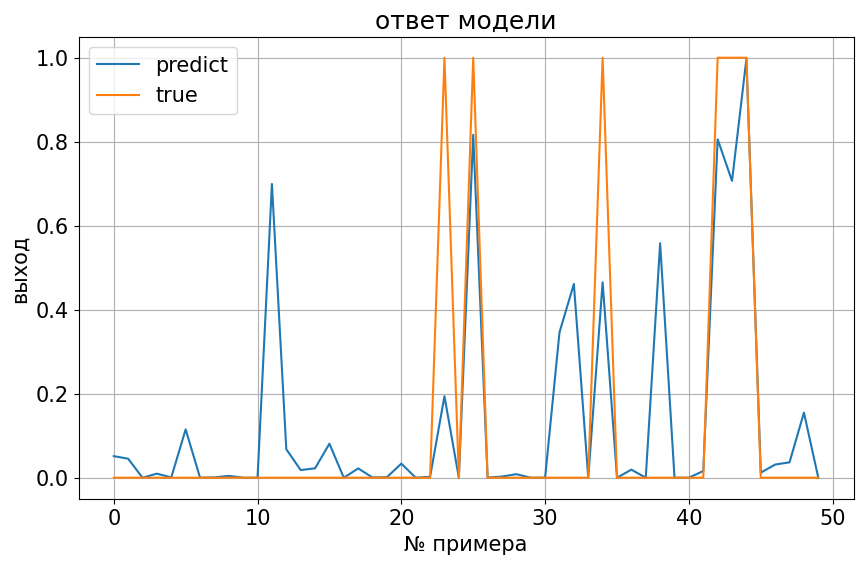

In [ ]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

Видим, что модель лучше улавливает зависимости в данных, хотя тоже совершает ошибки.

Рассчитаем precision, recall, порог и индекс максимального усредненного значения f-score.

In [ ]:
precision_tfidf, recall_tfidf, thresholds_tfidf = precision_recall_curve(y_test, preds)
fscore_tfidf = (2 * precision_tfidf * recall_tfidf) / (precision_tfidf + recall_tfidf)
ix = np.argmax(fscore_tfidf)
print(f'Best Threshold={thresholds_tfidf[ix]}, F-Score={fscore_tfidf[ix]:.3f}, Precision={precision_tfidf[ix]:.3f}, Recall={recall_tfidf[ix]:.3f}')

Best Threshold=0.4023580951399084, F-Score=0.842, Precision=0.821, Recall=0.864


Значение Best_Threshold изменилось, значения F-Score, Precision и Recall выросли.

Визуализируем матрицу ошибок.


Confusion matrix, without normalization
[[1681   69]
 [  25  225]]


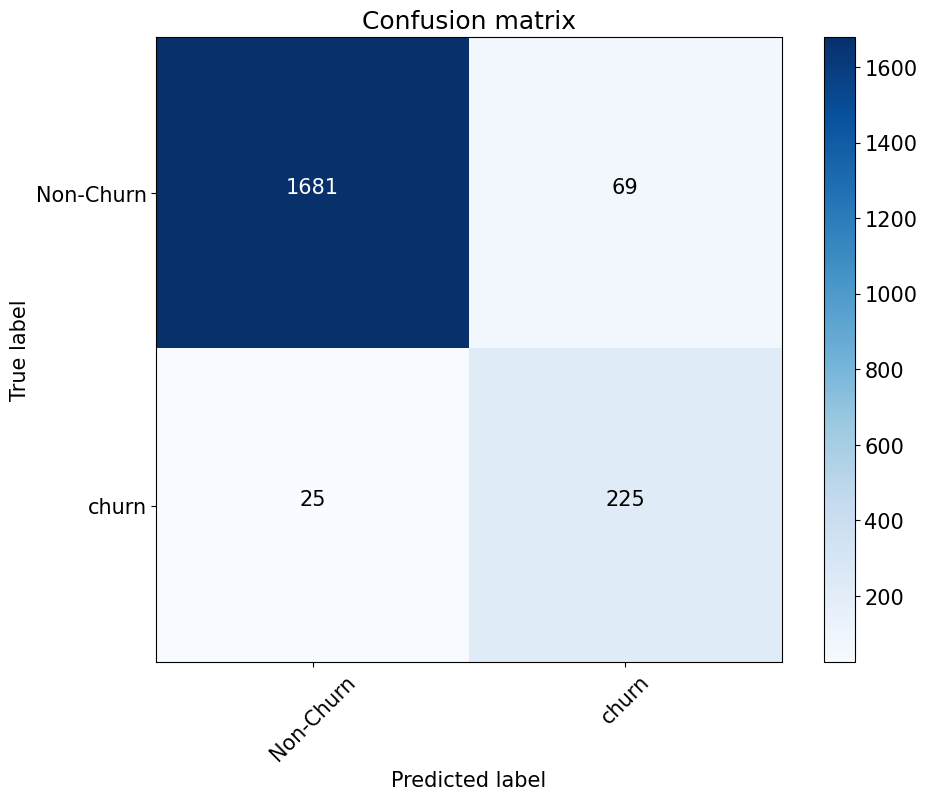

In [ ]:
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, preds > thresholds_mean[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Модель правильно предсказала, что 225 пользователей уйдут, 1681 пользователей останутся. Модель 69 раз совершила ошибку первого рода, т. е. предсказала, что пользователь уйдет, а он на самом деле остался. И также модель 25 раз совершила ошибку 2 рода, т. е. ошибочно предсказала, что пользователь не уйдет. Данной модели еще больше снизила ошибки второго рода. В целом данная модель сработала лучше предыдущих моделей.

Рассчитаем значение ROC AUC, чтобы понять насколько хорошо модель отличает классы между собой.


In [ ]:
roc_auc_score_tfidf = roc_auc_score(y_test, preds)
roc_auc_score_tfidf

0.9863908571428572

Мы получили самое большое значение roc_auc_score= 0.9864.

# Вывод

В работе выполнено прогнозирование оттока клиентов новостного портала.

Сначала были выделены темы, которые освещаются новостным порталом. Для получения векторов тем было обучено несколько моделей LDA, и выбрана модель с наибольшей когерентностью.

Затем были созданы векторы пользователей, состоящие из прочитанных ими тем. Эмбеддинги пользователей были получены на основе векторов тем при помощи одного из способов:
- mean,
- median,
- max,
- TF-IDF.

Эмбеддинги были использованы для предсказания оттока при обучении базовых моделей логистической регрессии.
Выведем в итоговую таблицу информацию по всем построенным моделям.

In [ ]:
pd.DataFrame({
    'metrics': ['precision', 'recall', 'f_score', 'roc_auc_score'],
    'mean_func': [f'{precision_mean[ix]:.3f}', f'{recall_mean[ix]:.3f}', f'{fscore_mean[ix]:.3f}', f'{roc_auc_score_mean:.4f}'],
    'median_func': [f'{precision_median[ix]:.3f}', f'{recall_median[ix]:.3f}', f'{fscore_median[ix]:.3f}', f'{roc_auc_score_median:.4f}'],
    'max_func': [f'{precision_max[ix]:.3f}', f'{recall_max[ix]:.3f}', f'{fscore_max[ix]:.3f}', f'{roc_auc_score_max:.4f}'],
    'tfidf_func': [f'{precision_tfidf[ix]:.3f}', f'{recall_tfidf[ix]:.3f}', f'{fscore_tfidf[ix]:.3f}', f'{roc_auc_score_tfidf:.4f}']
})

,metrics,mean_func,median_func,max_func,tfidf_func
0,precision,0.734,0.734,0.764,0.821
1,recall,0.772,0.772,0.804,0.864
2,f_score,0.752,0.752,0.784,0.842
3,roc_auc_score,0.9662,0.9697,0.9732,0.9864


Из получившихся значений можно сделать вывод, что наиболее эффективным оказался метод с использованием TfidfVectorizer для получения эмбеддингов пользователей - значения метрик самые высокие: precision= 0.821, recall= 0.864, f_score= 0.842, roc_auc= 0.9864.

Скорее всего, TfidfVectorizer лучше всего справился с задачей потому, что учитывает частоту слова; позволяет выделить ключевые слова, которые часто встречаются в одном документе, и менее распространены в других. Также возможно то, что TfidfVectorizer лучше всего подошел к этим данным.
